# Train network using location 1 data

## Import libraries

In [1]:
import os
import glob
import sys
import warnings
import re
import shutil

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm 

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from models import unetpp_level_1, unet_level_2

if not sys.warnoptions:
    warnings.simplefilter("ignore")

#### Check working enviroments

In [2]:
print("Tensorflow version: {}".format(tf.__version__))

Tensorflow version: 2.1.0


In [3]:
from tensorflow.python.client import device_lib
print("GPU sample processing: ")
print(device_lib.list_local_devices())

GPU sample processing: 
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8979881568278842155
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9992663860
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3333397293111168861
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


## Setup global variables

In [4]:
IMG_WIDTH = 912
IMG_HEIGHT = 912
IMG_CHANNELS = 3
BATCH_SIZE = 1
BURNED_PIXEL_VALUE = 1

CROP_HEIGHT = 228
CROP_WIDTH = 228

SEED = 42

In [5]:
IMAGE_PATH = "C:/Users/windows/Desktop/Research/3. Code/0.GITHUB-CODE/forest-fire-damage-mapping/sample_data/sample_location_1_data/Img"
MASK_PATH = "C:/Users/windows/Desktop/Research/3. Code/0.GITHUB-CODE/forest-fire-damage-mapping/sample_data/sample_location_1_data/Label"

## Data preprocessing

### Load data function

In [6]:
def load_images(path_data, img_height = 912, img_width = 912, normalize = True):
    imgs = glob.glob(path_data + "/*." + "png")
    imgs.sort()
    img_data = np.ndarray((len(imgs), img_height, img_width, 3), dtype=np.uint8)
    i = 0
    for x in range(len(imgs)):
        img_path = imgs[x]
        img = load_img(img_path, grayscale=False, target_size=[img_height, img_width])
        img = img_to_array(img)
        img_data[i] = img
        i += 1
    print("Loading success {} images with size {} into memory".format(len(imgs),img_data.shape))
    if normalize:
        img_data = img_data.astype('float32')
        img_data/=255
    return img_data

In [7]:
def load_masks(path_data, img_height = 912, img_width = 912, normalize = True):
    masks = glob.glob(path_data + "/*." + "png")
    masks.sort()
    mask_data = np.ndarray((len(masks), img_height, img_width, 1), dtype=np.bool)
    i = 0
    for x in range(len(masks)):
        mask_path = masks[x]
        mask = load_img(mask_path, grayscale=True, target_size=[img_height, img_width])
        mask = img_to_array(mask)
        mask_data[i] = mask
        i += 1
    print("Loading success {} masks with size {} into memory".format(len(masks),mask_data.shape))
    if normalize:
        mask_data = mask_data.astype('float32')
        mask_data /= np.max(mask_data)
        where_are_NaNs = np.isnan(mask_data)
        mask_data[where_are_NaNs] = 0
    return mask_data

In [8]:
X_train = load_images(IMAGE_PATH, img_height = 912, img_width = 912, normalize = True)
y_train = load_masks(MASK_PATH, img_height = 912, img_width = 912, normalize = True)

Loading success 24 images with size (24, 912, 912, 3) into memory
Loading success 24 masks with size (24, 912, 912, 1) into memory


In [9]:
def visualize_image_mask(X_train, y_train, num_show = 1):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(X_train[num_show])
    plt.title("Input image")


    plt.subplot(1,2,2)
    mask = np.ma.masked_where(y_train[num_show] == BURNED_PIXEL_VALUE, y_train[num_show])
    cmap = matplotlib.cm.Greys
    cmap.set_bad(color='black')
    plt.imshow(mask, cmap = cmap)
    plt.title("Input mask")
    plt.show()

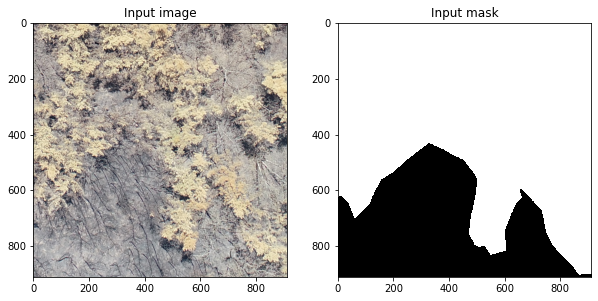

In [10]:
visualize_image_mask(X_train, y_train, num_show = 15)

### Data Augmentation

In [11]:
def data_augmentation(X_train, y_train):
    image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=90, zoom_range=0.5, width_shift_range=0.5,
                                             height_shift_range=0.5, fill_mode='reflect')
    mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=90, zoom_range=0.5, width_shift_range=0.5,
                                             height_shift_range=0.5, fill_mode='reflect')

    image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment= True, seed = SEED)
    mask_datagen.fit(y_train[:int(X_train.shape[0]*0.9)], augment= True, seed = SEED)
    x = image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)], batch_size= BATCH_SIZE, shuffle = True, seed = SEED)
    y = mask_datagen.flow(y_train[:int(X_train.shape[0]*0.9)], batch_size= BATCH_SIZE, shuffle = True, seed = SEED)

    image_datagen_val = image.ImageDataGenerator()
    mask_datagen_val = image.ImageDataGenerator()

    image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment= True, seed = SEED)
    mask_datagen_val.fit(y_train[int(X_train.shape[0]*0.9):], augment= True, seed = SEED)
    x_val = image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):], batch_size= BATCH_SIZE, shuffle = True, seed = SEED)
    y_val = mask_datagen_val.flow(y_train[int(X_train.shape[0]*0.9):], batch_size= BATCH_SIZE, shuffle = True, seed = SEED)

    train_generator = zip(x, y)
    val_generator = zip(x_val, y_val)
    return x, y, x_val, y_val, train_generator, val_generator

In [12]:
x, y, x_val, y_val, train_generator, val_generator = data_augmentation(X_train, y_train)

In [13]:
def visualize_augmented_image_mask(x, y):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(x.next()[0])
    plt.title("Input augmented image")

    plt.subplot(1,2,2)
    y_show = y.next()[0]
    mask = np.ma.masked_where(y_show == BURNED_PIXEL_VALUE, y_show)
    cmap = matplotlib.cm.Greys
    cmap.set_bad(color='black')
    plt.imshow(mask, cmap = cmap)
    plt.title("Input augmented mask")
    plt.show()

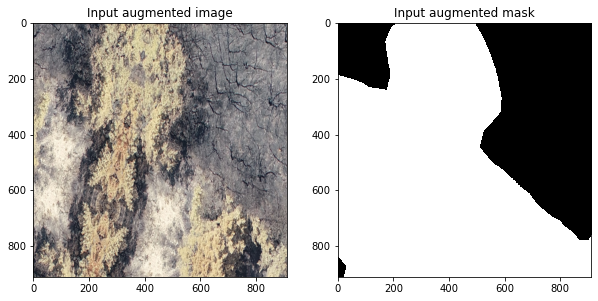

In [15]:
visualize_augmented_image_mask(x, y)

## Training configutation

### Implement loss functions

In [16]:
alpha = 0.25
gamma = 2
def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
    weight_a = alpha * (1 - y_pred) ** gamma * targets
    weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)

    return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(
        -logits)) * (weight_a + weight_b) + logits * weight_b

def focal_loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(),
                              1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))

    loss = focal_loss_with_logits(logits=logits, targets=y_true,
                                  alpha=alpha, gamma=gamma, y_pred=y_pred)
    return tf.reduce_mean(loss)

### Implement evaluation metrics

In [17]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (
                K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(
        K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

### Implement model checkpoint conditions

In [19]:
def get_checkpoint_best_only(network = 1):
    current_dir = os.getcwd()
    checkpoint_path = current_dir + "/model_checkpoint_network_{}/checkpoint".format(network)
    checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                                frequency = "epoch",
                                save_weights_only = True,
                                monitor = "val_dice_coef",
                                save_best_ony = True,
                                verbose = 1)
    return checkpoint

def get_early_stopping():
    early_stopping = EarlyStopping(monitor = "val_dice_coef", mode ="max", patience = 3)
    return early_stopping

In [20]:
checkpoint_best_only = get_checkpoint_best_only(network = 1)
early_stopping = get_early_stopping()
callbacks = [checkpoint_best_only, early_stopping]

### Create deep learning model

In [21]:
model_level_1 = unetpp_level_1.create_model()

### Compile

In [22]:
model_level_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), loss = focal_loss, metrics =[dice_coef, sensitivity, specificity, 'accuracy'])

In [23]:
steps_per_epoch = int( np.ceil(X_train[:int(X_train.shape[0]*0.9)].shape[0] / BATCH_SIZE))
validaton_step = int(np.ceil(X_train[int(X_train.shape[0]*0.9):].shape[0] / BATCH_SIZE))

### Train

In [24]:
model_level_1 = model_level_1.fit_generator(train_generator, validation_data=val_generator, validation_steps=validaton_step, steps_per_epoch=steps_per_epoch, epochs=30, callbacks = callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 21 steps, validate for 3 steps
Epoch 1/30
20/21 [===========================>..] - ETA: 0s - loss: 0.0942 - dice_coef: 0.2905 - sensitivity: 0.2003 - specificity: 0.6378 - accuracy: 0.5683
Epoch 00001: saving model to C:\Users\windows\Desktop\Research\3. Code\0.GITHUB-CODE\forest-fire-damage-mapping/model_checkpoint_network_1/checkpoint
21/21 [==============================] - 19s 882ms/step - loss: 0.0938 - dice_coef: 0.2767 - sensitivity: 0.1908 - specificity: 0.6551 - accuracy: 0.5888 - val_loss: 0.0704 - val_dice_coef: 0.4804 - val_sensitivity: 9.3401e-06 - val_specificity: 1.0000 - val_accuracy: 0.3945
Epoch 2/30
20/21 [===========================>..] - ETA: 0s - loss: 0.0739 - dice_coef: 0.2738 - sensitivity: 1.3131e-07 - specificity: 0.7982 - accuracy: 0.5602
Epoch 00002: saving model to C:\Users\windows\Desktop\Research\3. Code\0.GITHUB-CODE\fo

# Using pretrained model to extract global informations

### Load pretrained model

In [25]:
PATH_PRETRAINED = "C:/Users/windows/Desktop/Research/3. Code/0.GITHUB-CODE/forest-fire-damage-mapping/[Project]_Model_weights/network_1_weights/checkpoint"

In [26]:
PATH_SOURCE_PATCH_MASK = "C:/Users/windows/Desktop/Research/3. Code/6. UnetFire/ImgLabel/official_data_10.6/location_1_crop_for_2nd_network/Label/"
PATH_COPY_PATCH_MASK = "C:/Users/windows/Desktop/Research/3. Code/0.GITHUB-CODE/forest-fire-damage-mapping/sample_data/copy_for_network_2/Label/"

In [27]:
PATH_SOURCE_PATCH_IMG = "C:/Users/windows/Desktop/Research/3. Code/6. UnetFire/ImgLabel/official_data_10.6/location_1_crop_for_2nd_network/Img/"
PATH_COPY_PATCH_IMG= "C:/Users/windows/Desktop/Research/3. Code/0.GITHUB-CODE/forest-fire-damage-mapping/sample_data/copy_for_network_2/Img/"

In [28]:
model_level_1 = unetpp_level_1.create_model()
model_level_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), loss = focal_loss, metrics =[dice_coef, sensitivity, specificity, 'accuracy'])

In [29]:
model_level_1.load_weights(PATH_PRETRAINED)

### Extract cropped data

In [30]:
def extract_crop_num(result):
    crop_num = 1
    save_crop_burned_num = []
    for row in np.arange(0, IMG_HEIGHT, CROP_HEIGHT):
        for col in np.arange(0, IMG_WIDTH, CROP_WIDTH):
            crop_window = result[col:col+CROP_HEIGHT, row:row+CROP_WIDTH]
            if crop_window.any() == 1:
                save_crop_burned_num.append(crop_num)
            crop_num += 1
    return save_crop_burned_num

In [31]:
def copy_mask_to_network_2(path_source_mask, path_copy_mask ,num_img, save_crop_burned_num):
    for crop_num in save_crop_burned_num:
#         print('label{}crop{}'.format(num_img, crop_num))
        path_copy = path_copy_mask + 'label{}crop{}.png'.format(num_img, crop_num)
        path_source = path_source_mask + 'label{}crop{}.png'.format(num_img, crop_num)
        shutil.copyfile(path_source,path_copy)

In [32]:
def copy_img_to_network_2(path_source_img, path_copy_img ,num_img, save_crop_burned_num):
    for crop_num in save_crop_burned_num:
#         print('img{}crop{}'.format(num_img, crop_num))
        path_copy = path_copy_img + 'img{}crop{}.png'.format(num_img, crop_num)
        path_source = path_source_img + 'img{}crop{}.png'.format(num_img, crop_num)
        shutil.copyfile(path_source,path_copy)

In [33]:
def predict_network_1_and_copy_data_for_network_2():
    img_height = 912
    img_width = 912
    imgs = glob.glob(IMAGE_PATH + "/*." +"png")
    for num_img in tqdm(range(0,len(imgs))):
        img_path = imgs[num_img]
        img_name = img_path.split('/')[-1]
        # Extract testing image number
        temp = re.findall(r'\d+', img_name)
        res = list(map(int, temp))

        # Load testing image
        img = load_img(img_path, grayscale=False, target_size=[img_height, img_width])
        # preprocessing
        img = img_to_array(img)
        img = img.astype('float32')
        
        img /= 255
        img = img.reshape(1,img_height,img_width,3)
        # make prediction
        test_result = model_level_1.predict(img)
        # print(testResult)
        test_result[0,:,:,0][test_result[0,:,:,0] > 0.5] = 1
        test_result[0,:,:,0][test_result[0,:,:,0] <= 0.5] = 0
        test_result = test_result.reshape(img_height,img_width)
        save_crop_num = extract_crop_num(test_result)
        
        path_source_mask = PATH_SOURCE_PATCH_MASK
        path_copy_mask = PATH_COPY_PATCH_MASK
        copy_mask_to_network_2(path_source_mask, path_copy_mask, res[0], save_crop_num)
        
        path_source_img = PATH_SOURCE_PATCH_IMG
        path_copy_img = PATH_COPY_PATCH_IMG
        copy_img_to_network_2(path_source_img, path_copy_img, res[0], save_crop_num)

In [34]:
predict_network_1_and_copy_data_for_network_2()

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.51it/s]


# Train network 2 

### Data preprocessing

In [35]:
X_train_lv2 = load_images(PATH_COPY_PATCH_IMG,img_height = 128, img_width = 128, normalize = True)
y_train_lv2 = load_masks(PATH_COPY_PATCH_MASK,img_height = 128, img_width = 128, normalize = True)

Loading success 216 images with size (216, 128, 128, 3) into memory
Loading success 216 masks with size (216, 128, 128, 1) into memory


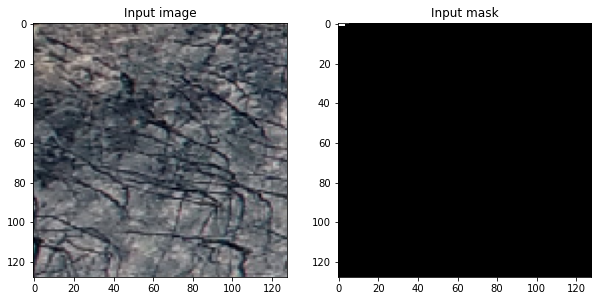

In [37]:
visualize_image_mask(X_train_lv2, y_train_lv2, num_show = 15)

In [36]:
x_lv2, y_lv2, x_val_lv2, y_val_lv_2, train_generator_lv2, val_generator_lv2 = data_augmentation(X_train_lv2, y_train_lv2)

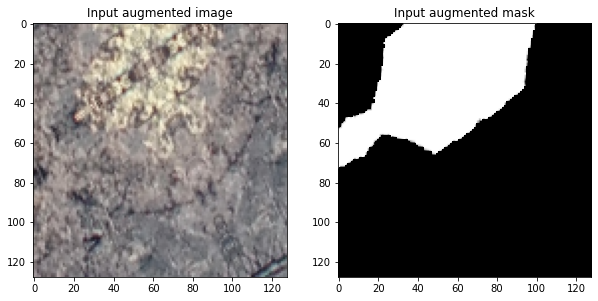

In [40]:
visualize_augmented_image_mask(x_lv2, y_lv2)

### Create model level 2

In [41]:
model_level_2 = unet_level_2.create_model()

In [42]:
model_level_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), loss = 'binary_crossentropy', metrics =[dice_coef, sensitivity, specificity, 'accuracy'])

In [45]:
steps_per_epoch = int( np.ceil(X_train_lv2[:int(X_train_lv2.shape[0]*0.9)].shape[0] / BATCH_SIZE))
validaton_step = int(np.ceil(X_train_lv2[int(X_train_lv2.shape[0]*0.9):].shape[0] / BATCH_SIZE))

In [47]:
checkpoint_best_only = get_checkpoint_best_only(network = 2)
early_stopping = get_early_stopping()

callbacks = [checkpoint_best_only, early_stopping]

In [48]:
 model_level_2 = model_level_2.fit_generator(train_generator, validation_data=val_generator, validation_steps=validaton_step, steps_per_epoch=steps_per_epoch, epochs=30, callbacks = callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 194 steps, validate for 22 steps
Epoch 1/30
193/194 [============================>.] - ETA: 0s - loss: 0.6269 - dice_coef: 0.2402 - sensitivity: 0.0165 - specificity: 0.9472 - accuracy: 0.6482
Epoch 00001: saving model to C:\Users\windows\Desktop\Research\3. Code\0.GITHUB-CODE\forest-fire-damage-mapping/model_checkpoint_network_2/checkpoint
194/194 [==============================] - 47s 242ms/step - loss: 0.6264 - dice_coef: 0.2410 - sensitivity: 0.0164 - specificity: 0.9474 - accuracy: 0.6482 - val_loss: 0.6617 - val_dice_coef: 0.4900 - val_sensitivity: 0.0199 - val_specificity: 0.9973 - val_accuracy: 0.3993
Epoch 2/30
193/194 [============================>.] - ETA: 0s - loss: 0.4871 - dice_coef: 0.3032 - sensitivity: 0.3190 - specificity: 0.7600 - accuracy: 0.7577
Epoch 00002: saving model to C:\Users\windows\Desktop\Research\3. Code\0.GITHUB-CODE\forest-fire-damage-mapping/model_checkpoint_network_2/checkpoint
194/194 [====